In [5]:
import torch, random, math, time, sys, os, tqdm
import numpy as np
import numba

In [6]:
from trainer.classification import Trainer
from trainer.attention_approx import Trainer as ApproxTrainer
batch_size = 8

trainer = Trainer(batch_size=batch_size, model='bert-mini')
trainer.load()
trainer.model.eval()
bert = trainer.model.bert
fc = trainer.model.classifier
batch = trainer.get_batch()
test_batch = trainer.get_batch(test=False)

approx_trainer = ApproxTrainer(batch_size=batch_size, factor=16, model=trainer.model_type)
approx_trainer.load()
approx_bert = approx_trainer.bert
approx_bert = approx_bert.eval()
print('approx trained', approx_trainer.steps)

100%|██████████| 7600/7600 [00:00<00:00, 211108.24it/s]


Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:1012, avg_len:236.477525, count:120000
Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:892, avg_len:235.2992105263158, count:7600


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainer.__init__: Model initialized. model = bert-mini
Trainer.load: Loading... saves/cls_bert-mini.pth


100%|██████████| 7600/7600 [00:00<00:00, 217143.80it/s]


Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:1012, avg_len:236.477525, count:120000
Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:892, avg_len:235.2992105263158, count:7600


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainer.__init__: Model initialized. model = bert-mini
Trainer.load: Loading... saves/cls_bert-mini.pth
Trainer.load: saves/att_approx_16_bert-mini.pth
approx trained 50000


In [7]:
import importlib
import models.sparse_token as sparse
importlib.reload(sparse)

<module 'models.sparse_token' from 'f:\\Library\\discrete_edge_learning\\models\\sparse_token.py'>

In [8]:
sparse_bert = sparse.SparseBertModel(bert.config)
sparse_bert.to(trainer.device)
sparse_bert.eval()
sparse_bert.load_state_dict(bert.state_dict())

<All keys matched successfully>

In [43]:
def eval_fc(lm_output, fc=fc, batch=batch):
    last_hidden = lm_output.last_hidden_state[:,0,:]
    x = fc(last_hidden)
    return torch.argmax(x, dim=-1), batch.labels, lm_output

def eval(bert, fc=fc, batch=batch):
    lm_output = bert(
        input_ids = batch.input_ids, 
        attention_mask = batch.attention_masks,
        output_hidden_states = True,
        output_attentions = True,
    )
    return eval_fc(lm_output, fc=fc, batch=batch)

def approx_eval(sparse_bert, approx_bert, fc=fc, batch=batch):
    lm_output = sparse.run_bert_with_approx(
        sparse_bert, 
        approx_bert, 
        {
            'input_ids': batch.input_ids,
            'attention_mask': batch.attention_masks,
            'output_hidden_states': True,
            'output_attentions': True,
        },
        ks = [0.25]*len(sparse_bert.encoder.layer),
    )
    return eval_fc(lm_output, fc=fc, batch=batch)
    
eval(bert)[:2], approx_eval(sparse_bert, approx_bert)[:2]

((tensor([1, 2, 4, 1, 3, 4, 3, 3], device='cuda:0'),
  tensor([1, 2, 4, 1, 3, 4, 3, 3], device='cuda:0')),
 (tensor([1, 2, 4, 1, 3, 4, 3, 3], device='cuda:0'),
  tensor([1, 2, 4, 1, 3, 4, 3, 3], device='cuda:0')))

In [64]:
importlib.reload(sparse)
def accuracy(batch_eval, N=720//16, return_lm=False):
    trainer.seed()
    trainer.dataset.batch_size = 16
    acc_sum = 0
    for i in tqdm.tqdm(range(N)):
        batch = trainer.get_batch(test=True)
        with torch.no_grad():
            output, label, _ = batch_eval(batch)
        acc_sum += torch.mean((output == label) * 1.0)
    if return_lm: return acc_sum.item() / N, _
    return acc_sum.item() / N

# setup for evaluation
sparse_bert = sparse.SparseBertModel(bert.config)
sparse_bert.to(trainer.device)
sparse_bert.eval()
sparse_bert.load_state_dict(bert.state_dict())
sparse.set_print(sparse_bert, False)
sparse.set_backup_last_inputs(sparse_bert, False)
sparse.set_output_masking(sparse_bert, False)

sparse_bert = sparse_bert.to(trainer.device)
approx_bert = approx_bert.to(trainer.device)
bert = bert.to(trainer.device)
sparse.set_print(sparse_bert, False)
sparse.set_backup_last_inputs(sparse_bert, False)
sparse.set_output_masking(sparse_bert, False)

sparse.timer_reset()
acc_approx, lm = accuracy(
    lambda batch: approx_eval(sparse_bert, approx_bert, batch=batch),
    return_lm = True,
)
acc_bert = acc_approx
#acc_bert = accuracy(lambda batch: eval(bert, batch=batch))
sparse.timer_report()
acc_bert, acc_approx, abs(acc_approx - 0.9236111111111112) < 0.001
#(0.934375, 0.92203125)
#(0.934375, 0.93359375)
# 0.8486328125

#(0.9243055555555556, 0.9173611111111111, False)

100%|██████████| 45/45 [00:01<00:00, 39.23it/s]

approx_att                   : 0:00:00.309996 (16.79%)
approx_mask_reset            : 0:00:00.013994 (0.76%)
approx_mask_reset_inverse    : 0:00:00.006000 (0.32%)
approx_mask_update           : 0:00:00.078007 (4.22%)
approx_sparse                : 0:00:00.503007 (27.24%)
bert.attention.output        : 0:00:00.069040 (3.74%)
bert.attention.probs.dropout : 0:00:00.003007 (0.16%)
bert.attention.qkv           : 0:00:00.154954 (8.39%)
bert.attention.scores.matmul : 0:00:00.021003 (1.14%)
bert.intermediate            : 0:00:00.069785 (3.78%)
bert.output                  : 0:00:00.053211 (2.88%)
sparselinear                 : 0:00:00.287205 (15.55%)
sparselinear.gather          : 0:00:00.075998 (4.12%)
sparselinear.linear          : 0:00:00.116000 (6.28%)
sparselinear.scatter_        : 0:00:00.085203 (4.61%)


(0.9194444444444444, 0.9194444444444444, False)

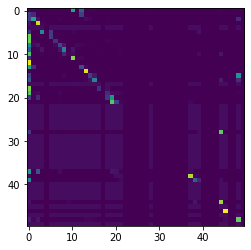

tensor([[2.4880e-03, 4.4412e-04, 3.4626e-04, 3.1635e-03, 0.0000e+00, 3.1504e-03,
         6.0098e-03],
        [1.7687e-01, 1.1223e-01, 1.0283e-03, 4.4937e-06, 0.0000e+00, 7.9757e-04,
         1.9282e-03]], device='cuda:0')


In [63]:
import matplotlib.pyplot as plt
def plot_grid(grid):
    plt.imshow(grid.cpu().detach().numpy())
    #plt.colorbar()
    plt.show()
plot_grid(lm.attentions[-2][0][0][:50, :50])
print(lm.attentions[-2][0][0][:2, :7])
#tensor([[0.0246, 0.0012, 0.0206, 0.0003, 0.0000, 0.0002, 0.0049]],

In [7]:
def benchmark(eval, batch_size=8, N=100, WARM=20, amp=False, device=trainer.device, end_warm=None):
    assert WARM < (N * 0.33)
    trainer.dataset.batch_size = batch_size
    batch = trainer.get_batch(test=True)
    batch = batch.to(device)
    assert batch.input_ids.shape[0] == batch_size
    for i in tqdm.tqdm(range(N)):
        if i == WARM: 
            t = time.time()
            if not end_warm is None: end_warm()
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=amp):
            eval(batch)
    t = time.time() - t
    t_item = t / (batch_size * (N-WARM))
    return t, t_item * 1000, 1.0/t_item

In [16]:
importlib.reload(sparse)
sparse.timer_reset()
benchmark_device = 'cuda'
benchmark_batch_size = 32

sparse_bert = sparse.SparseBertModel(bert.config)
sparse_bert.to(benchmark_device)
sparse_bert.eval()
sparse_bert.load_state_dict(bert.state_dict())
sparse.set_print(sparse_bert, False)
sparse.set_backup_last_inputs(sparse_bert, False)
sparse.set_output_masking(sparse_bert, False)

sparse_bert=sparse_bert.to(benchmark_device)
approx_bert=approx_bert.to(benchmark_device)
time_approx = benchmark(
    eval = lambda batch: approx_eval(sparse_bert, approx_bert, batch=batch, fc=lambda x: x),
    batch_size = benchmark_batch_size,
    WARM = 3,
    N = 25,
    device = benchmark_device,
    end_warm = lambda: sparse.timer_reset()
)
sparse.timer_report()
time_approx

# bert.attention.output        : 0:00:00.545988 (3.04%)
# bert.attention.probs.dropout : 0:00:00.006996 (0.04%)
# bert.attention.qkv           : 0:00:01.473990 (8.20%)
# bert.attention.scores.matmul : 0:00:00.113033 (0.63%)
# bert.intermediate            : 0:00:02.113082 (11.75%)
# bert.output                  : 0:00:01.848977 (10.28%)
# sparselinear.linear          : 0:00:03.801073 (21.14%)

# bert.attention.output        : 0:00:01.103962 (2.75%)
# bert.attention.probs.dropout : 0:00:00.010004 (0.02%)
# bert.attention.qkv           : 0:00:02.440944 (6.07%)
# bert.attention.scores.matmul : 0:00:00.534112 (1.33%)
# bert.intermediate            : 0:00:02.811061 (6.99%)
# bert.output                  : 0:00:02.548062 (6.34%)
# sparselinear                 : 0:00:07.770034 (19.33%)
# sparselinear.gather          : 0:00:01.343004 (3.34%)
# sparselinear.linear          : 0:00:04.463333 (11.11%)
# sparselinear.scatter_        : 0:00:01.947706 (4.85%)

100%|██████████| 25/25 [00:01<00:00, 14.46it/s]

approx_att                   : 0:00:00.530008 (16.51%)
approx_mask_reset            : 0:00:00.009992 (0.31%)
approx_mask_reset_inverse    : 0:00:00.002000 (0.06%)
approx_mask_update           : 0:00:00.082006 (2.55%)
approx_sparse                : 0:00:00.917022 (28.56%)
bert.attention.output        : 0:00:00.162011 (5.05%)
bert.attention.probs.dropout : 0:00:00.001000 (0.03%)
bert.attention.qkv           : 0:00:00.240004 (7.47%)
bert.attention.scores.matmul : 0:00:00.048999 (1.53%)
bert.intermediate            : 0:00:00.111025 (3.46%)
bert.output                  : 0:00:00.100998 (3.15%)
sparselinear                 : 0:00:00.507026 (15.79%)
sparselinear.gather          : 0:00:00.104996 (3.27%)
sparselinear.linear          : 0:00:00.285007 (8.88%)
sparselinear.scatter_        : 0:00:00.109022 (3.40%)


(1.556016445159912, 2.2102506323294207, 452.43737763173175)

In [13]:
bert = bert.to(benchmark_device)
time_bert = benchmark(
    lambda batch: eval(bert, batch=batch, fc=lambda x: x), 
    batch_size = benchmark_batch_size,
    WARM = 3,
    N=25,
    device = benchmark_device
)
time_bert

100%|██████████| 25/25 [00:01<00:00, 12.99it/s]


(1.742016315460205, 2.474454993551428, 404.12939520260323)

In [10]:
torch.ones(2,2).unsqueeze(-1).repeat(1, 1, 12)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])